In [6]:
%matplotlib inline

import numpy as np
# from bokeh.plotting import figure, show, output_file
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools as it
from xcel_to_df import xcel_to_df, combine_lists, needs_formatting, reformat_multiple_columns

In [7]:
def find_19_dataframe(file_prefix, quarter):
    prefix = 'excel_data/2019_data/'
    files = os.listdir(prefix)
    
    dict_list = []
    
    for file in files:
        if file.startswith(file_prefix): 
#         df = pd.read_excel('excel_data/2019_data/Sp19_wk2_B.xlsx')
            df = pd.read_excel(prefix + file)
            days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
            times= ['8', '10', '12', '2']
            col_names = combine_lists(days, times)
            if needs_formatting(df):
                df = reformat_multiple_columns(df, col_names, start=3, end=7)
                print('Fixed formatting')
                
                
            df_19 = df.drop(columns=['Structure', 'Lot'])
#             print(df_19)
            positions = ['8am', '10am', '12pm', '2pm']

            df_19['8am'] = [0 for i in range(0, len(df_19))]
            df_19['9am'] = [0 for i in range(0, len(df_19))]
            df_19['10am'] = [0 for i in range(0, len(df_19))]
            df_19['11am'] = [0 for i in range(0, len(df_19))]
            df_19['12pm'] = [0 for i in range(0, len(df_19))]
            df_19['1pm'] = [0 for i in range(0, len(df_19))]
            df_19['2pm'] = [0 for i in range(0, len(df_19))]
            df_19['3pm'] = [0 for i in range(0, len(df_19))]
            df_19['4pm'] = [0 for i in range(0, len(df_19))]
            df_19['5pm'] = [0 for i in range(0, len(df_19))]

            for time, pos in zip(times, positions):
                for day in days:
                    df_19[pos] += df_19[day + '-' + time].astype(float) / 5.0
                    df_19 = df_19.drop(columns=[day + '-' + time])

            df_19['9am'] = (df_19['8am'] + df_19['10am']) / 2.0
            df_19['11am'] = (df_19['10am'] + df_19['12pm']) / 2.0
            df_19['1pm'] = (df_19['12pm'] + df_19['2pm']) / 2.0
            df_19['3pm'] = (df_19['10am']) * 0.9
            df_19['4pm'] = (df_19['9am']) * 0.9
            df_19['5pm'] = (df_19['8am']) * 0.9

            # df_temp['Structure'] = df['Structure']
            # df_temp['Lot'] = df['Lot']
            # df_temp['date'] = ['2019 Spring' for x in range(0,len(df_temp))]

            df_19 = df_19.sum()
            # df_temp.head()

            df_19['date'] = '2019 ' + quarter
            df_19['year'] = '2019'
            df_new_dict = df_19.to_dict()
            df_new_dict.pop('Total Spaces')
            dict_list.append(df_new_dict)
            # df_19 = df_19.join(df_19[s].stack().reset_index(level=1, drop=True).rename('empty_spaces'))
            # df_new = pd.concat([df_temp,df_19])
            
    return dict_list

In [14]:
file_list = ['Win19_wk2','Sp19_wk2']
quarter_list = ['Winter', 'Spring']
dict_list = [find_19_dataframe(x,y) for x,y in zip(file_list,quarter_list)]
data_list = []
for i in dict_list:
    for j in i[0]:
        if isinstance(i[0][j], str):
            continue
#         print('Right')
        for idx in range(1, len(i)):
            i[0][j] += i[idx][j]
    data_list.append(i[0])
# data_list

Fixed formatting


In [15]:
prefix = 'csv_data/University-Wide/'
s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
def get_df(filename):
    df_University_Wide = pd.read_csv(prefix + filename)
    df_useful = df_University_Wide
#     df_useful = df_useful.loc[(df_useful['quarter'] == 'Summer') | (df_useful['quarter'] == 'Fall')]
    df_useful['date'] = df_useful['year'] + " " + df_useful['quarter']
    remain = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','date','year']
    df_useful = df_useful[remain]

    for data in data_list:
        df_useful.loc[len(df_useful) + 1] = data
    s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
    df_temp = df_useful.drop(columns = s, axis = 1)
    df_temp = df_temp.loc[(df_temp.year == '2000/01') | (df_temp.year == '2004/05') | (df_temp.year == '2010/11') | (df_temp.year == '2014/15') | (df_temp.year == '2019')]
    order = df_temp['date'].to_list()
    df_temp = df_temp.join(df_useful[s].stack().reset_index(level = 1, drop = True).rename('empty_spaces'))
    df_temp = df_temp.reset_index(drop = True)

    time_list = [s[i % 10] for i in range(0,len(df_temp))]
    df_temp['time'] = time_list

    return df_temp,order

# def get_total_data():
#     files = os.listdir(prefix)
#     df = []
#     for file in files:
#         df.append(get_df(file))
#     df_whole = pd.concat(df)
# #     df_whole = df_whole.groupby('groupID').sum()
#     return df_whole

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


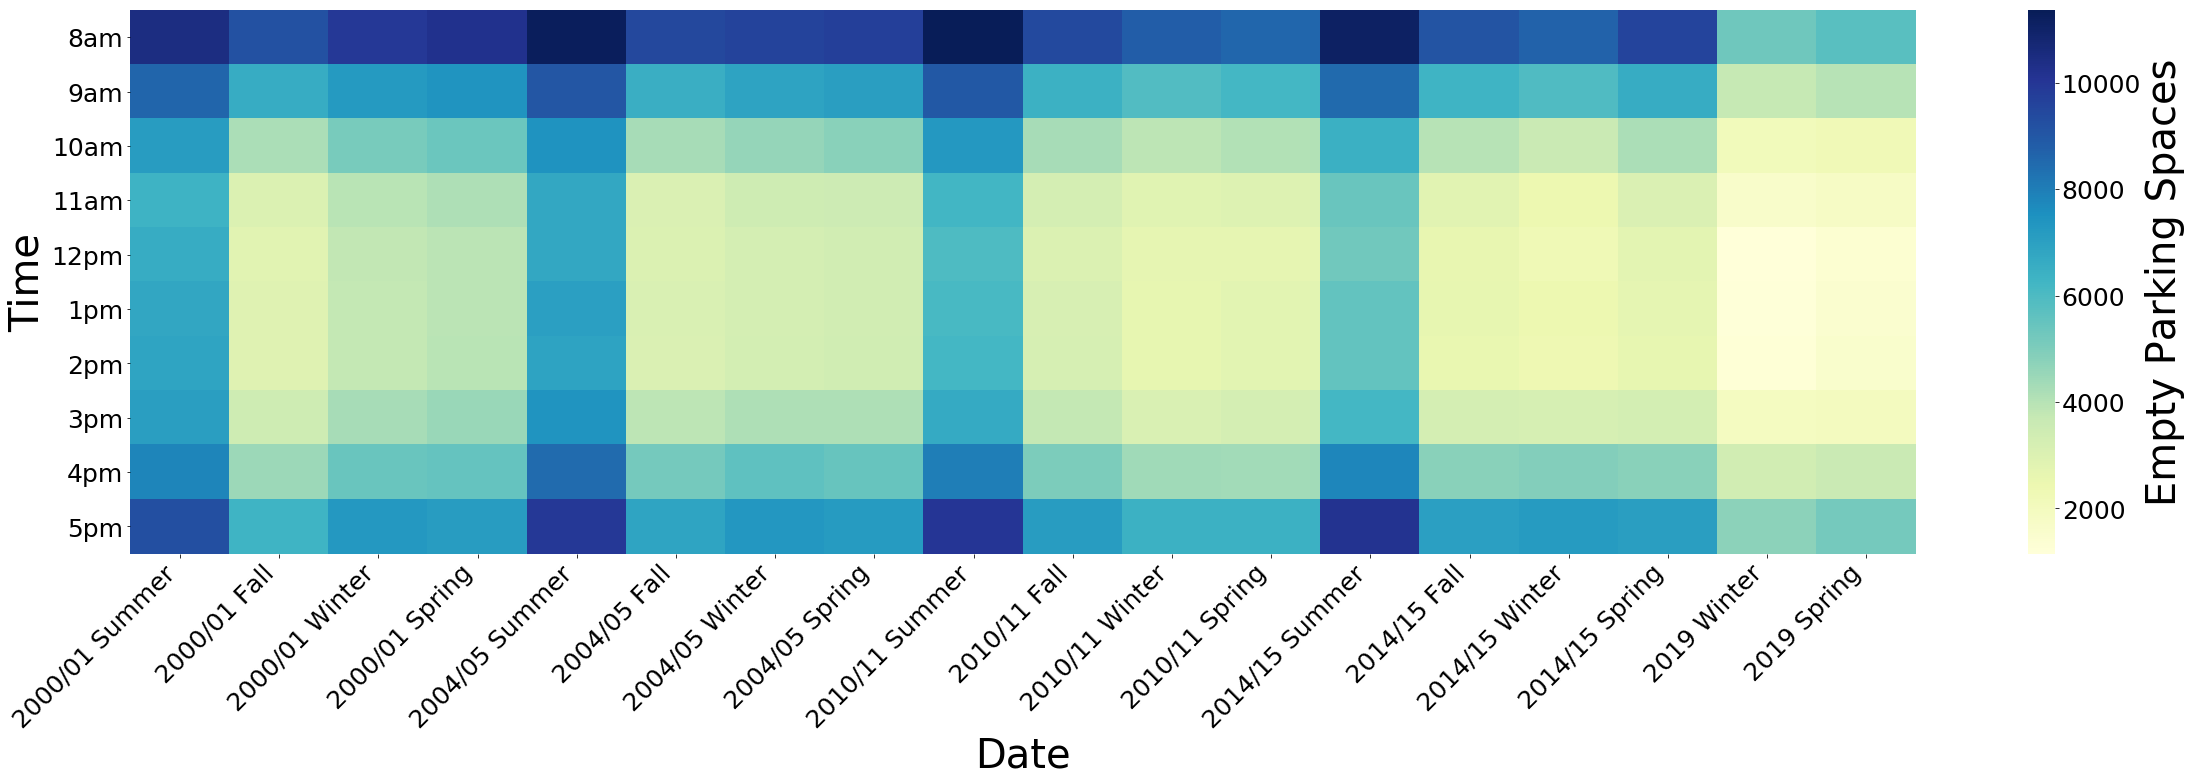

In [16]:
df_temp,order = get_df('University_of_California,_San_Diego__All_Parking_Spaces_Combined.csv')
# spaces_data = df_temp.pivot('time','date','empty_spaces').reindex(s)
spaces_data =  df_temp.pivot('time','date','empty_spaces').reindex(s, columns = order)
# spaces_data = spaces_data.reindex(s)
# cols = []
# for x in spaces_data.columns:
#     if not str(x).startswith('2019') and (str(x).endswith('Fall')):
#         cols.append(x)
# spaces_data = spaces_data.drop(columns = cols,axis = 1)


f, ax = plt.subplots(figsize=(40, 10))
# ax =sns.heatmap(spaces_data,annot=True,fmt = '.1f', cmap='YlGnBu',ax=ax,cbar_kws={'label': 'Empty Parking Spaces'})
ax =sns.heatmap(spaces_data, cmap='YlGnBu',ax=ax,cbar_kws={'label': 'Empty Parking Spaces'})
ax.figure.axes[-1].yaxis.label.set_size(40)
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right',fontsize = 25)
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right',fontsize = 25)
plt.rcParams['font.size'] = 25
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Time', fontsize = 40)
# plt.savefig('emptyspaces_heatmap_LaJollaCampusS.png')
plt.savefig("images/empty_spaces_heatmap.jpg", bbox_inches = 'tight')
plt.show()